In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.stats import norm, skew # 수치해석 기능(확률분포) 제공
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,f1_score,roc_curve,roc_auc_score

train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/데이콘/천체 유형 분류/train.csv')
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/데이콘/천체 유형 분류/test.csv')
sample_submission = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/데이콘/천체 유형 분류/sample_submission.csv')

train_id = train['id']
test_id = test['id']

# 필요없는 Id 컬럼, Drop하자.
#train.drop('id',axis=1,inplace=True)
#test.drop('id',axis=1,inplace=True)

# 'Id'를 제거한 DataFrame의 Shape 확인
print("The train data size after dropping ID feature is : {} ".format(train.shape))
print("The test data size after dropping Id feature is : {} ".format(test.shape))

unique_labels = train['type'].unique()
label_dict = {val: i for i, val in enumerate(unique_labels)}
i2lb = {v:k for k, v in label_dict.items()}

The train data size after dropping ID feature is : (199991, 23) 
The test data size after dropping Id feature is : (10009, 22) 


In [0]:
train.head()

,id,type,fiberID,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z
0,0,QSO,601,23.198224,21.431953,21.314148,21.176553,21.171444,22.581309,21.644453,21.657571,21.387653,21.572827,22.504317,21.431636,21.478312,21.145409,20.422446,22.749241,21.465534,21.364187,21.020605,21.147340
1,1,QSO,788,21.431355,20.708104,20.678850,20.703420,20.473229,21.868797,21.029773,20.967054,20.937731,21.063646,21.360701,20.778968,20.889705,20.639812,20.646660,21.492955,20.758527,20.753925,20.693389,20.512314
2,2,QSO,427,17.851451,16.727898,16.679677,16.694640,16.641788,18.171890,17.033098,16.999682,17.095999,17.076449,17.867253,16.738784,16.688874,16.744210,16.808006,17.818063,16.697434,16.641249,16.660177,16.688928
3,3,QSO,864,20.789900,20.040371,19.926909,19.843840,19.463270,21.039030,20.317165,20.217898,20.073852,19.794505,20.433907,19.993727,19.985531,19.750917,19.455117,20.770711,20.001699,19.889798,19.758113,19.552855
4,4,STAR_RED_DWARF,612,26.454969,23.058767,21.471406,19.504961,18.389096,25.700632,23.629122,21.742750,19.861718,18.810375,25.859229,22.426929,21.673551,19.610012,18.376141,24.877052,23.147993,21.475342,19.487330,18.375655


In [0]:
test.head()

,id,fiberID,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z
0,199991,251,23.817399,22.508963,20.981106,18.517316,17.076079,25.053890,23.167848,21.335901,18.835858,17.434384,22.246697,22.796239,21.195315,18.584486,17.154284,25.391534,22.499435,21.011918,18.499341,17.091474
1,199992,386,22.806983,21.937111,20.335770,20.000512,19.527369,22.498565,22.186000,20.618879,20.301204,20.030078,21.729831,21.837511,20.196128,19.967204,19.683671,22.475338,21.853442,20.173169,19.796757,19.567372
2,199993,232,21.024250,19.235669,18.304061,17.808608,17.380113,21.205546,19.439533,18.344433,17.909690,17.538164,20.722629,18.710223,17.611851,17.158519,16.843986,20.579314,18.653338,17.562108,17.120529,16.708748
3,199994,557,20.503424,20.286261,20.197204,20.162419,20.059832,20.976132,20.611498,20.567262,20.479318,20.277472,20.329269,20.385262,20.129157,20.206574,20.212342,20.479879,20.280943,20.150499,20.206221,20.092909
4,199995,75,24.244851,22.668237,21.239333,19.284777,18.235939,25.681860,22.935289,21.642456,19.624926,18.591749,22.308298,22.957496,21.285033,19.299120,18.307526,25.489360,22.857290,21.191862,19.237964,18.280368


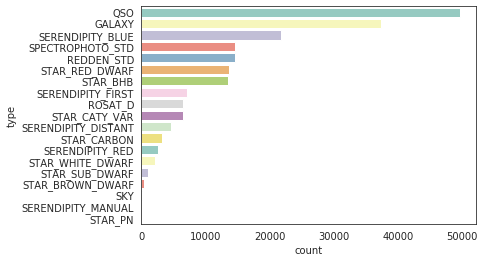

QSO                    49680
GALAXY                 37347
SERENDIPITY_BLUE       21760
SPECTROPHOTO_STD       14630
REDDEN_STD             14618
STAR_RED_DWARF         13750
STAR_BHB               13500
SERENDIPITY_FIRST       7132
ROSAT_D                 6580
STAR_CATY_VAR           6506
SERENDIPITY_DISTANT     4654
STAR_CARBON             3257
SERENDIPITY_RED         2562
STAR_WHITE_DWARF        2160
STAR_SUB_DWARF          1154
STAR_BROWN_DWARF         500
SKY                      127
SERENDIPITY_MANUAL        61
STAR_PN                   13
Name: type, dtype: int64


In [0]:
sns.set_style('white')
sns.countplot(y=train['type'],
              order = train['type'].value_counts().index,
              palette="Set3")
# plt.xticks(rotation='90')
plt.show()

print(train['type'].value_counts())

In [0]:
# TRAIN 데이터의 TYPE을 SAMPLE_SUBMISSION에 대응하는 가변수 형태로 변환시킵니다.
column_number = {}
for i, column in enumerate(sample_submission.columns):
    column_number[column] = i
    
def to_number(x, dic):
    return dic[x]

train['type'] = train['type'].apply(lambda x: to_number(x, column_number))

In [0]:
train.head()

,id,type,fiberID,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z
0,0,9,601,23.198224,21.431953,21.314148,21.176553,21.171444,22.581309,21.644453,21.657571,21.387653,21.572827,22.504317,21.431636,21.478312,21.145409,20.422446,22.749241,21.465534,21.364187,21.020605,21.147340
1,1,9,788,21.431355,20.708104,20.678850,20.703420,20.473229,21.868797,21.029773,20.967054,20.937731,21.063646,21.360701,20.778968,20.889705,20.639812,20.646660,21.492955,20.758527,20.753925,20.693389,20.512314
2,2,9,427,17.851451,16.727898,16.679677,16.694640,16.641788,18.171890,17.033098,16.999682,17.095999,17.076449,17.867253,16.738784,16.688874,16.744210,16.808006,17.818063,16.697434,16.641249,16.660177,16.688928
3,3,9,864,20.789900,20.040371,19.926909,19.843840,19.463270,21.039030,20.317165,20.217898,20.073852,19.794505,20.433907,19.993727,19.985531,19.750917,19.455117,20.770711,20.001699,19.889798,19.758113,19.552855
4,4,11,612,26.454969,23.058767,21.471406,19.504961,18.389096,25.700632,23.629122,21.742750,19.861718,18.810375,25.859229,22.426929,21.673551,19.610012,18.376141,24.877052,23.147993,21.475342,19.487330,18.375655


In [0]:
train['type'].value_counts()

9     49680
7     37347
19    21760
16    14630
5     14618
11    13750
6     13500
14     7132
12     6580
2      6506
8      4654
15     3257
4      2562
1      2160
17     1154
3       500
10      127
18       61
13       13
Name: type, dtype: int64

- 데이터에는 NA가 없음
- 심한 불균형 Class Data
- Train에 심한 이상치가 들어 있어서 왜도를 상당히 심하게 만듬.

# Data Preprocess

In [0]:
col_list = ['psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i','psfMag_z', 
            'fiberMag_u', 'fiberMag_g', 'fiberMag_r', 'fiberMag_i','fiberMag_z', 
            'petroMag_u', 'petroMag_g', 'petroMag_r', 'petroMag_i','petroMag_z',
            'modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i','modelMag_z']

## 음수 제거

In [0]:
for col in ['psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i','psfMag_z', 
            'fiberMag_u', 'fiberMag_g', 'fiberMag_r', 'fiberMag_i','fiberMag_z', 
            'petroMag_u', 'petroMag_g', 'petroMag_r', 'petroMag_i','petroMag_z',
            'modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i','modelMag_z']:

            train.drop(train[train[col]<0].index,axis=0,inplace=True)

train.shape

(199775, 23)

In [0]:
train.describe()

,id,type,fiberID,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z
count,199775.000000,199775.000000,199775.000000,199775.000000,199775.000000,199775.000000,199775.000000,199775.000000,199775.000000,199775.000000,199775.000000,199775.000000,199775.000000,199775.000000,199775.000000,199775.000000,199775.000000,199775.000000,199775.000000,199775.000000,199775.000000,199775.000000,199775.000000
mean,99989.916206,9.877793,360.854451,20.987046,19.860984,19.288714,18.872313,18.612499,21.172838,21.331811,19.505597,19.087514,18.828646,21.612984,19.609804,19.019285,18.609252,18.465849,20.730298,19.530579,18.939891,18.520490,18.276621
std,57735.199457,4.625531,225.333492,2.247905,1.863039,1.727366,1.628048,1.686594,1.983103,554.988577,1.704242,1.626396,1.677075,392.078346,2.534950,2.735432,1.927741,20.261355,2.185596,1.958846,1.860367,1.796456,1.866562
min,0.000000,1.000000,1.000000,2.667644,2.741681,11.017885,5.917322,1.762241,2.001454,7.251943,11.795394,10.646672,8.049850,0.333675,0.615563,0.028206,0.189286,0.643462,3.444448,12.498143,11.802798,11.337467,10.977328
25%,49991.500000,7.000000,174.000000,19.652742,18.701651,18.048764,17.747568,17.425649,19.941607,18.903846,18.259929,17.904648,17.607014,19.249466,18.114730,17.480902,17.051597,16.805719,19.265795,18.075800,17.423288,16.977746,16.705478
50%,99984.000000,9.000000,349.000000,20.870483,19.903740,19.454268,19.043471,18.610969,21.049216,20.069257,19.632518,19.189932,18.711755,20.367212,19.586342,19.183791,18.694250,18.174592,20.405463,19.546735,19.142977,18.641756,18.100543
75%,149990.500000,12.000000,526.000000,22.158334,21.148721,20.515141,20.072956,19.883066,22.336923,21.385562,20.774074,20.332017,20.133490,21.796790,21.002898,20.457082,20.018739,19.807081,21.989800,20.960870,20.407302,19.968548,19.819232
max,199990.000000,19.000000,1000.000000,368.939515,61.356278,117.565177,61.241476,81.345680,105.085577,248077.513380,31.928244,42.002047,40.860707,175257.982891,566.468016,809.628220,122.271336,8647.360709,49.487277,59.987842,35.102312,45.783550,61.597879


In [0]:
test.describe()

,id,fiberID,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z
count,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000
mean,204995.000000,359.327805,20.987400,19.878440,19.280218,18.873165,18.618385,21.184506,20.091376,19.497732,19.083329,18.826624,20.715429,19.462021,18.995001,18.616519,18.411996,20.739001,19.534844,18.935095,18.522308,18.281069
std,2889.493756,223.928862,2.111703,2.573890,1.709344,1.720713,1.702236,1.990940,1.865064,1.710070,1.633953,1.711790,2.807434,13.971203,1.979225,1.970463,2.373022,2.187025,1.957506,1.856617,1.796820,1.867582
min,199991.000000,1.000000,-7.248195,-42.663871,9.134712,-22.522266,13.349827,9.390439,8.188752,12.288183,12.688984,-8.455932,-98.181975,-1348.068776,-23.908952,-8.356654,-64.917293,12.419765,13.617577,13.382832,12.955113,12.395695
25%,202493.000000,174.000000,19.655525,18.671025,18.037847,17.742016,17.424701,19.940430,18.892043,18.253627,17.905253,17.610776,19.249432,18.104265,17.475078,17.043615,16.805557,19.268471,18.064625,17.424393,16.971911,16.715685
50%,204995.000000,346.000000,20.854404,19.910333,19.444925,19.033283,18.594713,21.040735,20.071658,19.627904,19.180605,18.699819,20.371014,19.582955,19.197068,18.684269,18.171966,20.412702,19.541261,19.155839,18.635195,18.095883
75%,207497.000000,525.000000,22.160801,21.150040,20.489912,20.083814,19.878652,22.339213,21.402558,20.756306,20.331848,20.119736,21.803705,21.025719,20.428279,20.015701,19.815916,21.992969,20.981396,20.389215,19.970657,19.823902
max,209999.000000,1000.000000,37.681143,182.654452,31.883768,47.227391,34.946057,41.169991,47.160580,29.266687,31.146742,26.478564,65.392087,106.962571,41.850633,52.221528,74.747394,32.641240,28.814977,27.579664,26.471555,24.461973


하지만 몇몇 컬럼의 표준편차는 너무 큰 양수 값 때문에 차이가 많이 나는 것으로 보인다. 좀 더 지워보자.

## 500 이상 데이터 제거

In [0]:
for col in col_list:
  train.drop(train[train[col]>500].index,axis=0,inplace=True)

train.shape

(199764, 23)

## 파생변수 만들기

In [0]:
k=5
for idx,col in enumerate (col_list):
  for j in range(k):
    train['%s_%s*%s'%(col[:3],
                      col[-1],
                      col_list[idx+j][-1])] = train[col] * train[col_list[idx+j]]
    test['%s_%s*%s'%(col[:3],
                     col[-1],
                     col_list[idx+j][-1])] = test[col] * test[col_list[idx+j]]
  k-=1
  if k==0:
    k=5

In [0]:
train.head()

,id,type,fiberID,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z,psf_u*u,psf_u*g,psf_u*r,psf_u*i,psf_u*z,psf_g*g,psf_g*r,psf_g*i,psf_g*z,psf_r*r,psf_r*i,psf_r*z,psf_i*i,psf_i*z,psf_z*z,fib_u*u,fib_u*g,...,fib_g*g,fib_g*r,fib_g*i,fib_g*z,fib_r*r,fib_r*i,fib_r*z,fib_i*i,fib_i*z,fib_z*z,pet_u*u,pet_u*g,pet_u*r,pet_u*i,pet_u*z,pet_g*g,pet_g*r,pet_g*i,pet_g*z,pet_r*r,pet_r*i,pet_r*z,pet_i*i,pet_i*z,pet_z*z,mod_u*u,mod_u*g,mod_u*r,mod_u*i,mod_u*z,mod_g*g,mod_g*r,mod_g*i,mod_g*z,mod_r*r,mod_r*i,mod_r*z,mod_i*i,mod_i*z,mod_z*z
0,0,9,601,23.198224,21.431953,21.314148,21.176553,21.171444,22.581309,21.644453,21.657571,21.387653,21.572827,22.504317,21.431636,21.478312,21.145409,20.422446,22.749241,21.465534,21.364187,21.020605,21.147340,538.157599,497.183257,494.450379,491.258420,491.139907,459.328627,456.803825,453.854896,453.745406,454.292902,451.360182,451.251294,448.446395,448.338210,448.230051,509.915503,488.760078,...,468.482351,468.766278,462.924049,466.932046,469.050377,463.204607,467.215033,457.431693,461.392137,465.386871,506.444301,482.304330,483.354742,475.863003,459.593196,459.315005,460.315348,453.180708,437.686410,461.317870,454.167691,438.639649,447.128336,431.840970,417.076281,517.527987,488.324605,486.019048,478.202816,481.085944,460.769129,458.593671,451.218499,453.938936,456.428485,449.088133,451.795726,441.865830,444.529879,447.209990
1,1,9,788,21.431355,20.708104,20.678850,20.703420,20.473229,21.868797,21.029773,20.967054,20.937731,21.063646,21.360701,20.778968,20.889705,20.639812,20.646660,21.492955,20.758527,20.753925,20.693389,20.512314,459.302969,443.802724,443.175775,443.702335,438.769025,428.825571,428.219780,428.728569,423.961746,427.614844,428.122915,423.362826,428.631590,423.865845,419.153088,478.244289,459.895838,...,442.251349,440.932394,440.315722,442.963688,439.617373,439.002540,441.642609,438.388567,441.024943,443.677174,456.279566,443.853330,446.218754,440.880867,441.027134,431.765508,434.066512,428.873996,429.016280,436.379779,431.159591,431.302633,426.001849,426.143180,426.284557,461.947115,446.162082,446.063182,444.762071,440.870245,430.916434,430.820913,429.564262,425.805423,430.725414,429.469041,425.711035,428.216334,424.469289,420.755032
2,2,9,427,17.851451,16.727898,16.679677,16.694640,16.641788,18.171890,17.033098,16.999682,17.095999,17.076449,17.867253,16.738784,16.688874,16.744210,16.808006,17.818063,16.697434,16.641249,16.660177,16.688928,318.674315,298.617256,297.756443,298.023551,297.080065,279.822569,279.015935,279.266232,278.382128,278.211626,278.461201,277.579646,278.711001,277.828654,276.949101,330.217592,309.523586,...,290.126428,289.557246,291.197821,290.864827,288.989180,290.626537,290.294197,292.273171,291.938947,291.605106,319.238723,299.076091,298.184338,299.173033,300.312893,280.186900,279.351469,280.277720,281.345587,278.518528,279.442017,280.506701,280.368569,281.436782,282.509066,317.483361,297.515933,296.514813,296.852088,297.364374,278.804313,277.866156,278.182219,278.662286,276.931156,277.246155,277.724607,277.561513,278.040509,278.520332
3,3,9,864,20.789900,20.040371,19.926909,19.843840,19.463270,21.039030,20.317165,20.217898,20.073852,19.794505,20.433907,19.993727,19.985531,19.750917,19.455117,20.770711,20.001699,19.889798,19.758113,19.552855,432.219942,416.637309,414.278441,412.551439,404.639444,401.616469,399.342645,397.677906,390.051158,397.081694,395.426380,387.842812,393.777967,386.226013,378.818892,442.640794,427.453447,...,412.787189,410.770364,407.843762,402.168230,408.763394,405.851090,400.203288,402.959535,397.351973,391.822444,417.544547,408.549957,408.382468,403.588397,397.544054,399.749124,399.585244,394.894444,388.980307,399.421431,394.732554,388.820841,390.098721,384.256407,378.501589,431.422441,415.449517,413.125257,410.390056,406.126702,400.067973,397.829765,395.195832,391.090325,395.604079,392.

In [0]:
test.head()

,id,fiberID,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z,psf_u*u,psf_u*g,psf_u*r,psf_u*i,psf_u*z,psf_g*g,psf_g*r,psf_g*i,psf_g*z,psf_r*r,psf_r*i,psf_r*z,psf_i*i,psf_i*z,psf_z*z,fib_u*u,fib_u*g,fib_u*r,...,fib_g*g,fib_g*r,fib_g*i,fib_g*z,fib_r*r,fib_r*i,fib_r*z,fib_i*i,fib_i*z,fib_z*z,pet_u*u,pet_u*g,pet_u*r,pet_u*i,pet_u*z,pet_g*g,pet_g*r,pet_g*i,pet_g*z,pet_r*r,pet_r*i,pet_r*z,pet_i*i,pet_i*z,pet_z*z,mod_u*u,mod_u*g,mod_u*r,mod_u*i,mod_u*z,mod_g*g,mod_g*r,mod_g*i,mod_g*z,mod_r*r,mod_r*i,mod_r*z,mod_i*i,mod_i*z,mod_z*z
0,199991,251,23.817399,22.508963,20.981106,18.517316,17.076079,25.053890,23.167848,21.335901,18.835858,17.434384,22.246697,22.796239,21.195315,18.584486,17.154284,25.391534,22.499435,21.011918,18.499341,17.091474,567.268505,536.104949,499.715378,441.034303,406.707793,506.653399,472.262931,416.805569,384.364826,440.206809,388.513766,358.275026,342.890984,316.203149,291.592477,627.697397,580.444724,534.547321,...,536.749203,494.306929,436.386309,403.917170,455.220685,401.880012,371.978300,354.789555,328.391588,303.957751,494.915507,507.141019,471.525741,413.443410,381.626149,519.668529,483.173474,423.656380,391.053162,449.241378,393.904025,363.590451,345.383102,318.803541,294.269456,644.730001,571.295163,533.524827,469.726646,433.978747,506.224562,472.756273,416.224714,384.548506,441.500690,388.706632,359.124649,342.225616,316.181007,292.118487
1,199992,386,22.806983,21.937111,20.335770,20.000512,19.527369,22.498565,22.186000,20.618879,20.301204,20.030078,21.729831,21.837511,20.196128,19.967204,19.683671,22.475338,21.853442,20.173169,19.796757,19.567372,520.158463,500.319304,463.797557,456.151332,445.360369,481.236822,446.108037,438.753443,428.374054,413.543544,406.725812,397.104086,400.020479,390.557378,381.318141,506.185410,499.153157,463.895192,...,492.218601,457.450462,450.402512,444.387313,425.138191,418.588076,412.997764,412.138880,406.634698,401.204025,472.185544,474.525411,438.858453,433.883956,427.722844,476.876872,441.033171,436.034024,429.842380,407.883604,403.260210,397.533952,398.689223,393.027872,387.446912,505.140820,491.163495,453.398803,444.938811,439.783309,477.572925,440.853188,432.627285,427.614436,406.956766,399.363338,394.735919,391.911597,387.370521,382.882062
2,199993,232,21.024250,19.235669,18.304061,17.808608,17.380113,21.205546,19.439533,18.344433,17.909690,17.538164,20.722629,18.710223,17.611851,17.158519,16.843986,20.579314,18.653338,17.562108,17.120529,16.708748,442.019104,404.415520,384.829157,374.412634,365.403845,370.010960,352.090854,342.560489,334.318098,335.038641,325.969844,318.126643,317.146520,309.515618,302.068324,449.675188,412.225914,389.003717,...,377.895444,356.607207,348.156006,340.933720,336.518215,328.543101,321.727673,320.756988,314.103079,307.587200,429.427346,387.725001,364.963860,355.569627,349.051678,350.072435,329.521663,321.039718,315.154738,310.177311,302.193293,296.653786,294.414784,289.017865,283.719878,423.508184,383.872909,361.416145,352.328759,343.854577,347.947020,327.591939,319.355023,311.673922,308.427641,300.672589,293.440837,293.112528,286.062610,279.182256
3,199994,557,20.503424,20.286261,20.197204,20.162419,20.059832,20.976132,20.611498,20.567262,20.479318,20.277472,20.329269,20.385262,20.129157,20.206574,20.212342,20.479879,20.280943,20.150499,20.206221,20.092909,420.390408,415.937808,414.111835,413.398625,411.295241,411.532367,409.725735,409.020079,406.938972,407.927033,407.224475,405.152505,406.523127,404.454725,402.396848,439.998110,432.349507,431.421595,...,424.833862,423.922080,422.109424,417.949077,423.012254,421.203489,417.052071,419.402458,415.268791,411.175867,413.279184,414.417476,409.211043,410.784888,410.902151,415.558902,410.338129,411.916309,412.033895,405.182946,406.741299,406.857407,408.305645,408.422200,408.538789,419.425457,415.351259,412.679795,413.820959,411.500358,

In [0]:
col_list=['psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i',
       'psfMag_z', 'fiberMag_u', 'fiberMag_g', 'fiberMag_r', 'fiberMag_i',
       'fiberMag_z', 'petroMag_u', 'petroMag_g', 'petroMag_r', 'petroMag_i',
       'petroMag_z', 'modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i',
       'modelMag_z', 'psf_u*u', 'psf_u*g', 'psf_u*r', 'psf_u*i', 'psf_u*z',
       'psf_g*g', 'psf_g*r', 'psf_g*i', 'psf_g*z', 'psf_r*r', 'psf_r*i',
       'psf_r*z', 'psf_i*i', 'psf_i*z', 'psf_z*z', 'fib_u*u', 'fib_u*g',
       'fib_u*r', 'fib_u*i', 'fib_u*z', 'fib_g*g', 'fib_g*r', 'fib_g*i',
       'fib_g*z', 'fib_r*r', 'fib_r*i', 'fib_r*z', 'fib_i*i', 'fib_i*z',
       'fib_z*z', 'pet_u*u', 'pet_u*g', 'pet_u*r', 'pet_u*i', 'pet_u*z',
       'pet_g*g', 'pet_g*r', 'pet_g*i', 'pet_g*z', 'pet_r*r', 'pet_r*i',
       'pet_r*z', 'pet_i*i', 'pet_i*z', 'pet_z*z', 'mod_u*u', 'mod_u*g',
       'mod_u*r', 'mod_u*i', 'mod_u*z', 'mod_g*g', 'mod_g*r', 'mod_g*i',
       'mod_g*z', 'mod_r*r', 'mod_r*i', 'mod_r*z', 'mod_i*i', 'mod_i*z',
       'mod_z*z']

## 박스콕스변환
- test 데이터에 음수가 있으므로 우선 생략

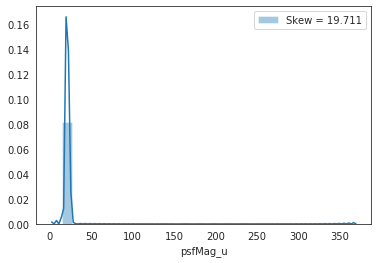

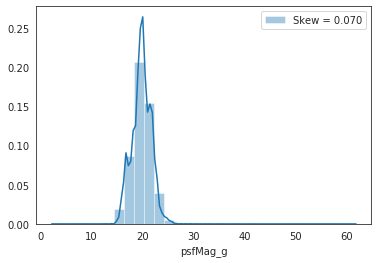

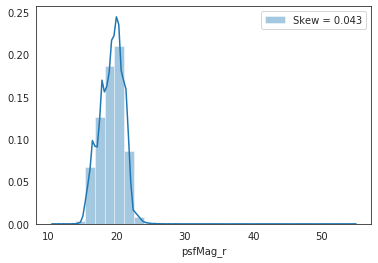

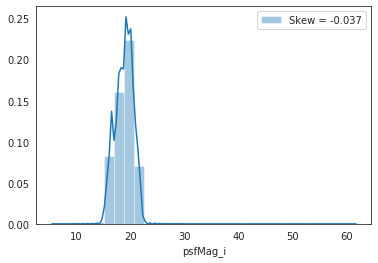

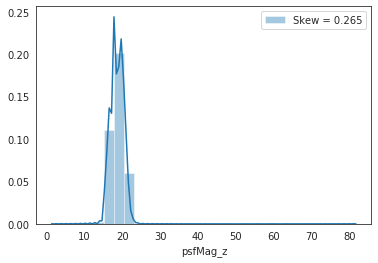

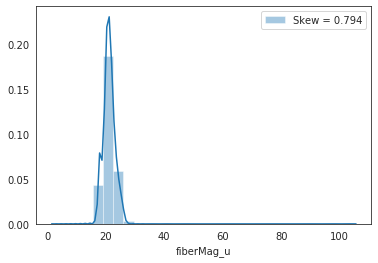

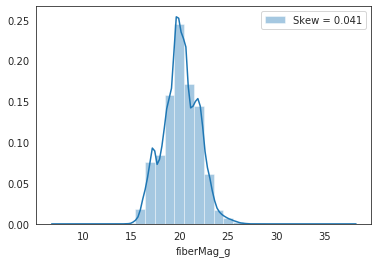

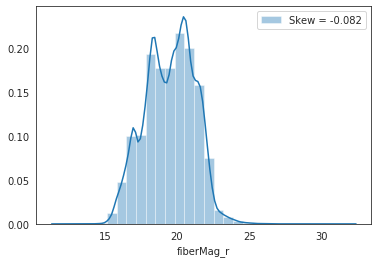

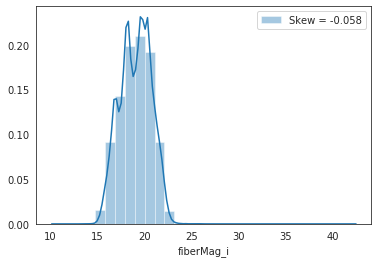

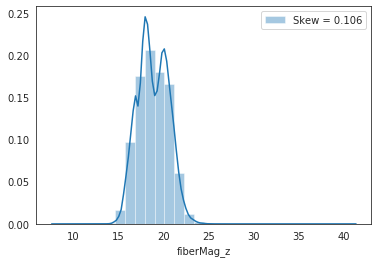

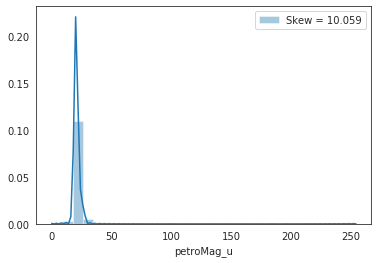

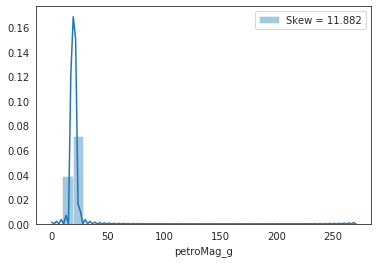

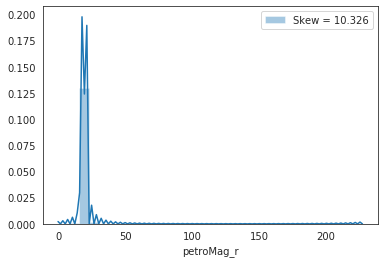

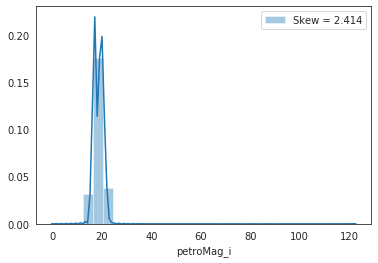

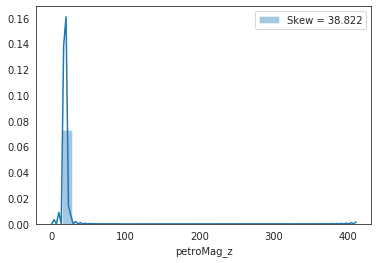

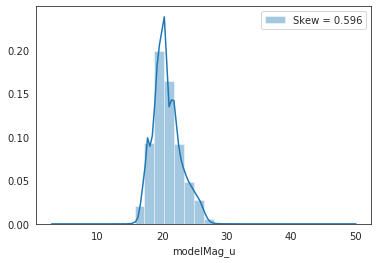

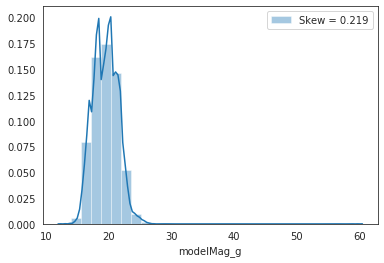

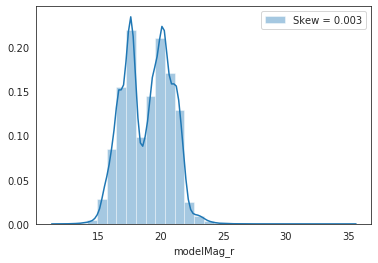

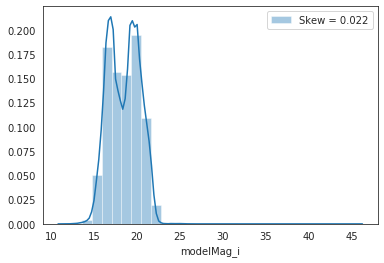

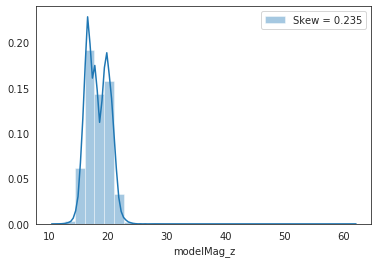

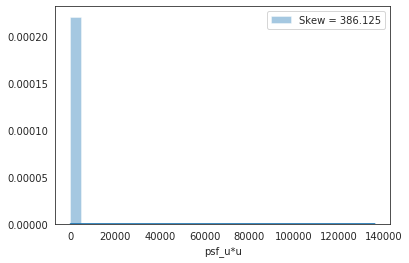

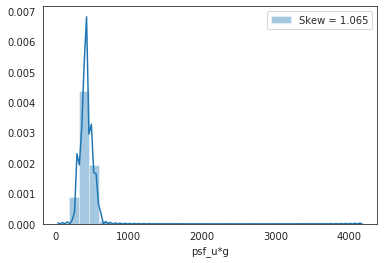

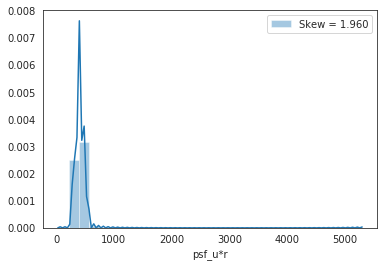

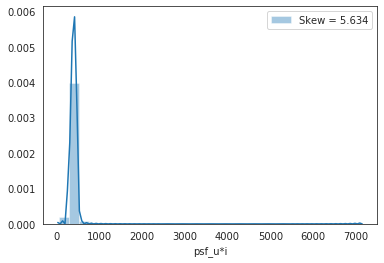

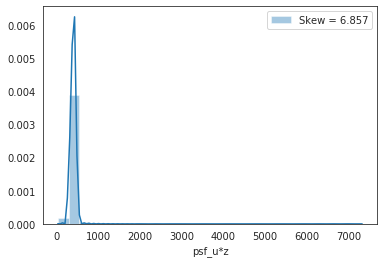

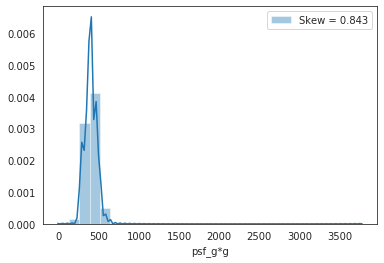

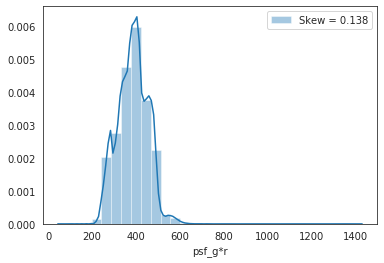

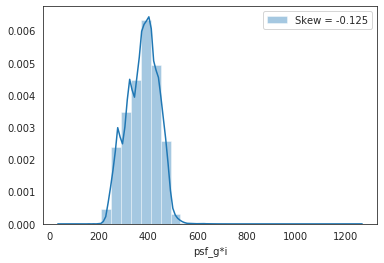

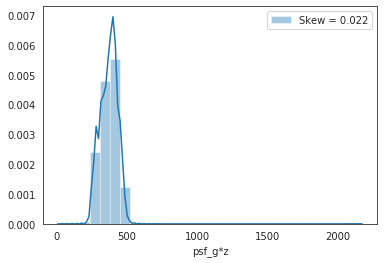

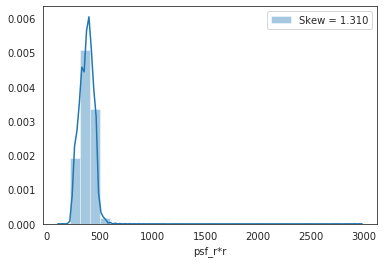

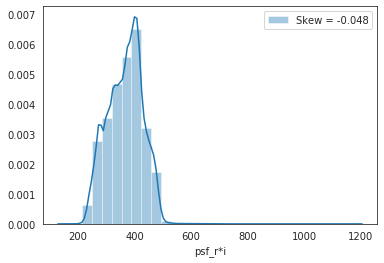

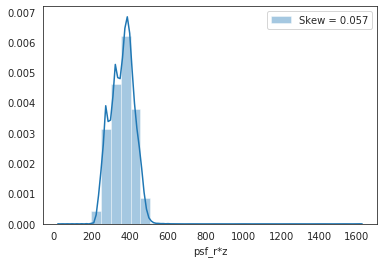

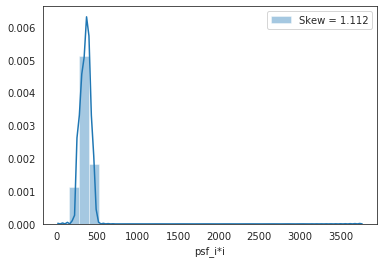

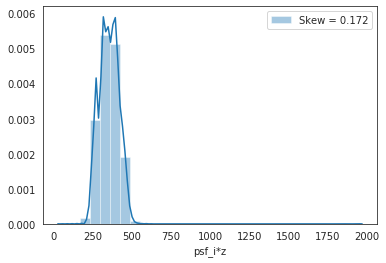

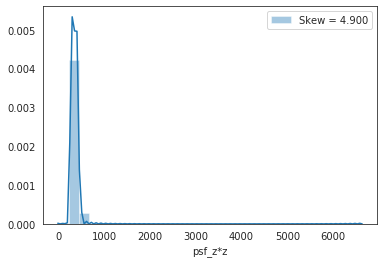

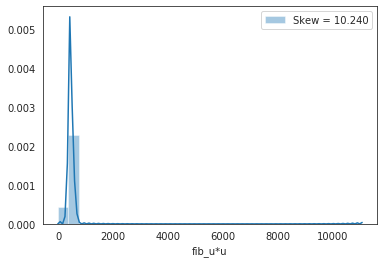

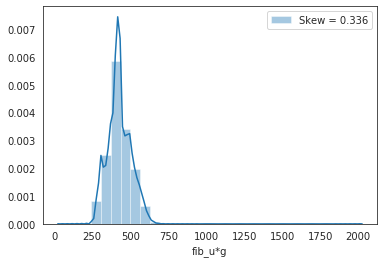

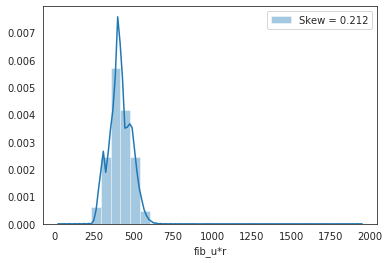

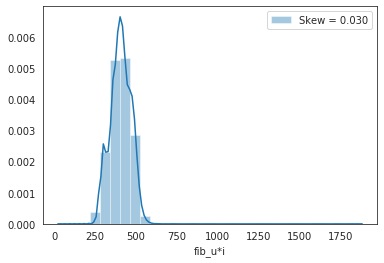

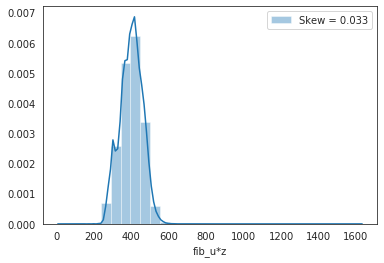

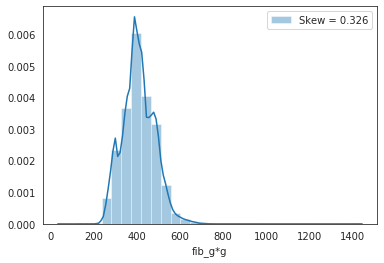

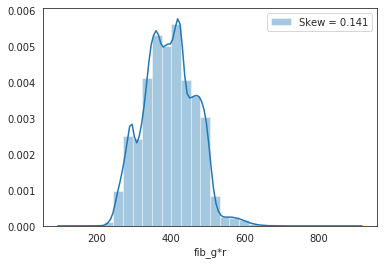

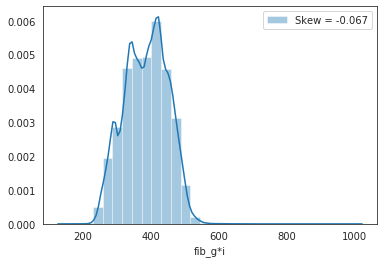

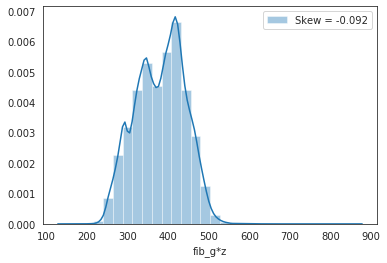

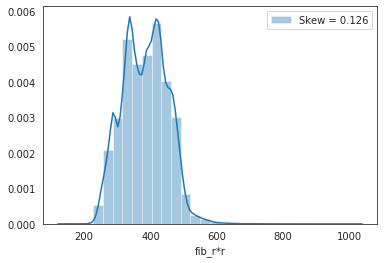

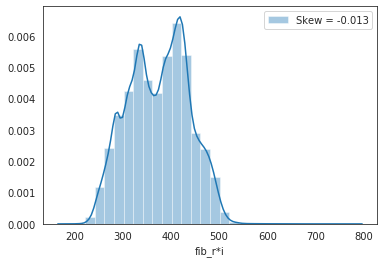

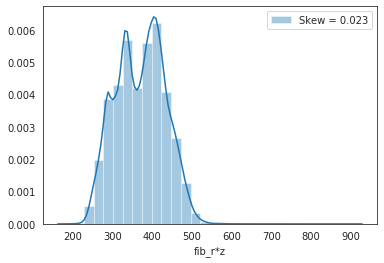

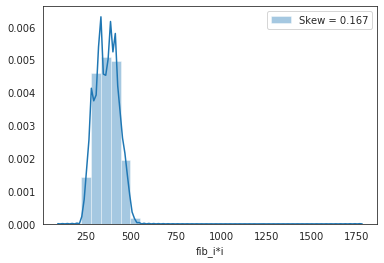

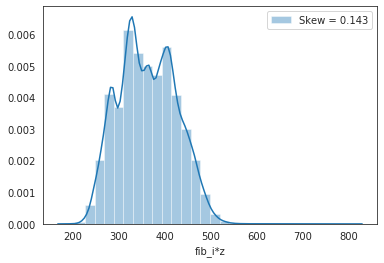

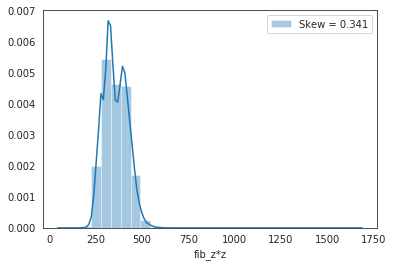

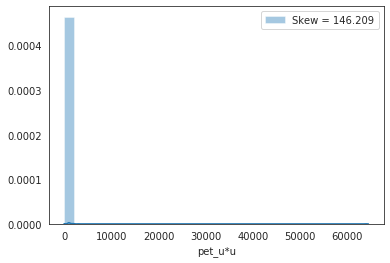

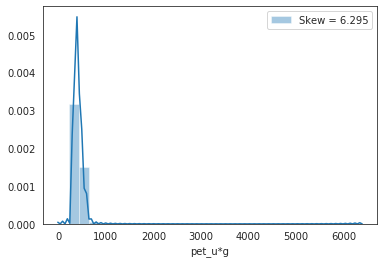

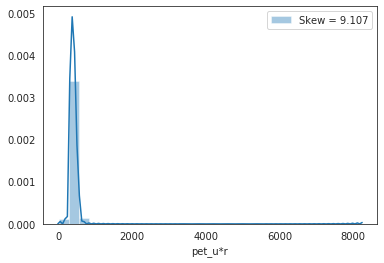

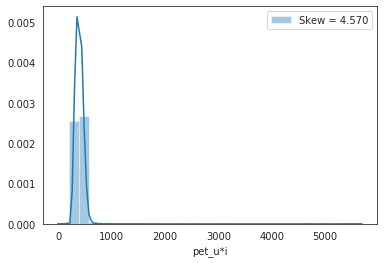

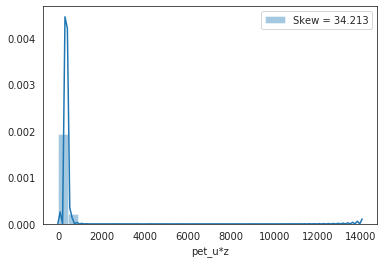

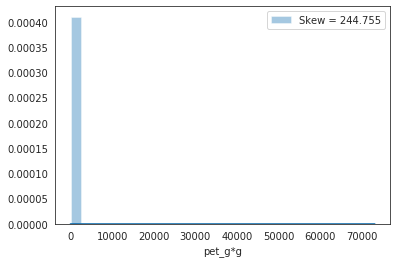

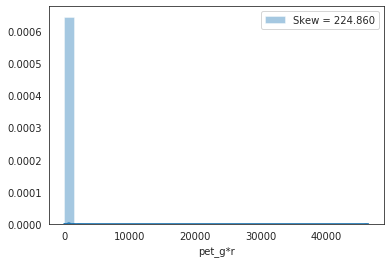

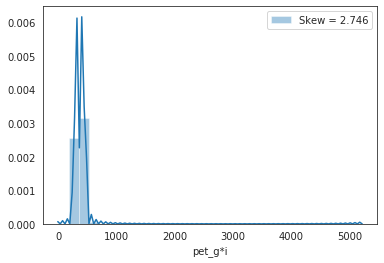

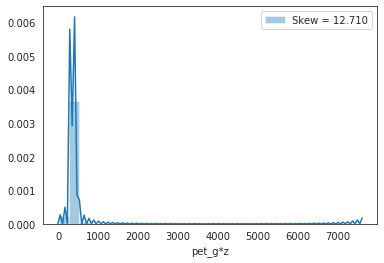

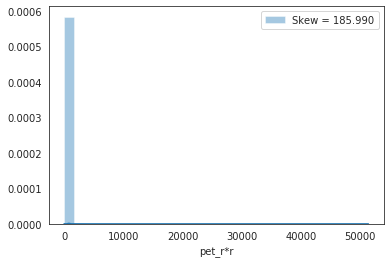

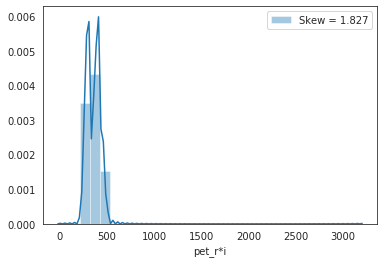

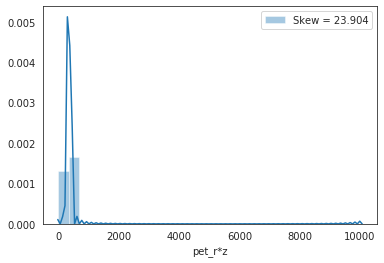

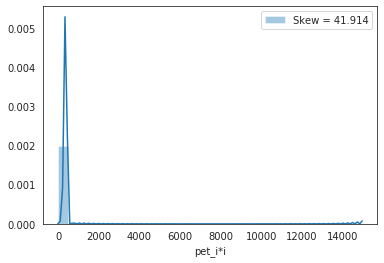

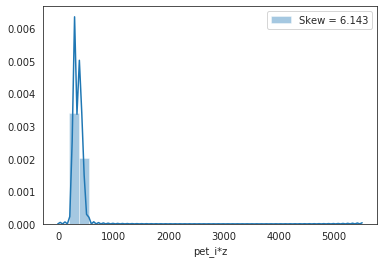

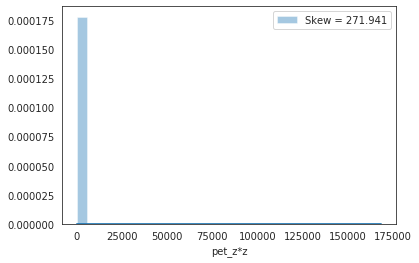

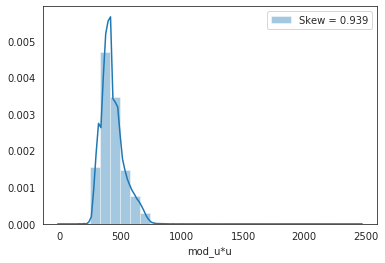

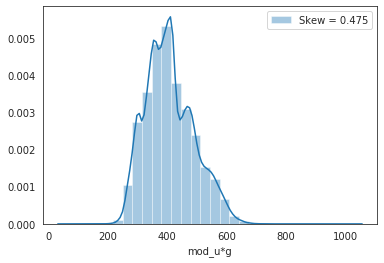

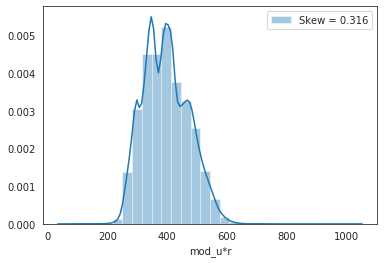

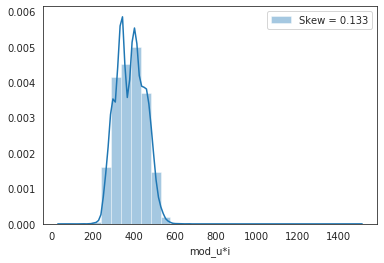

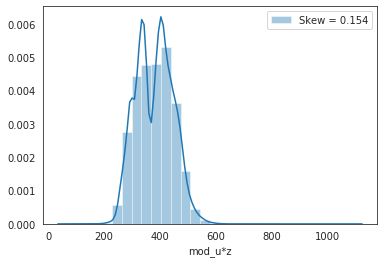

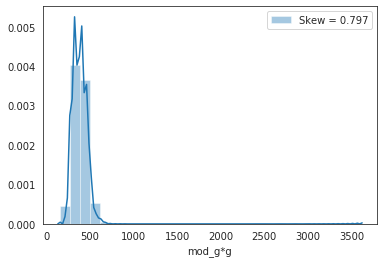

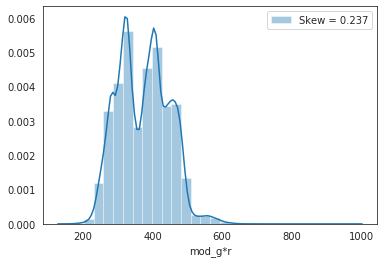

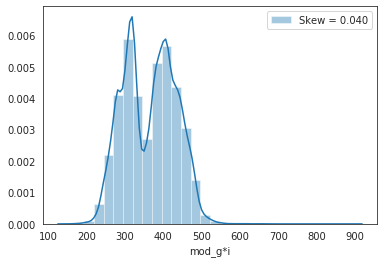

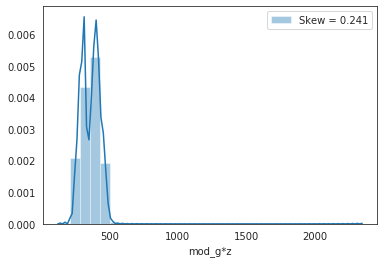

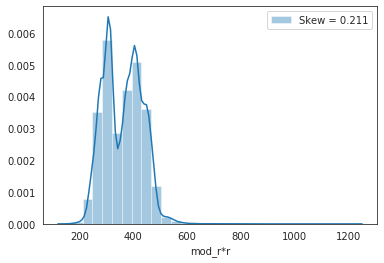

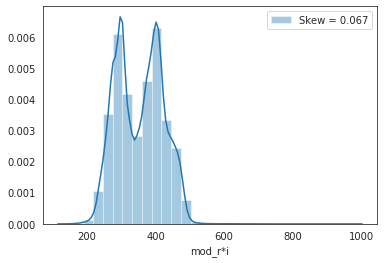

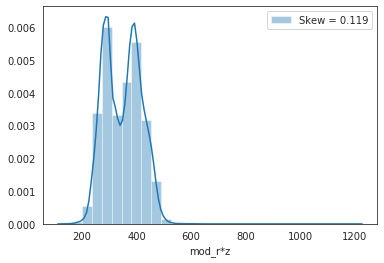

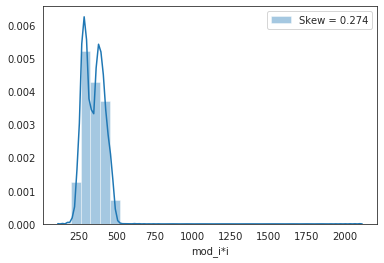

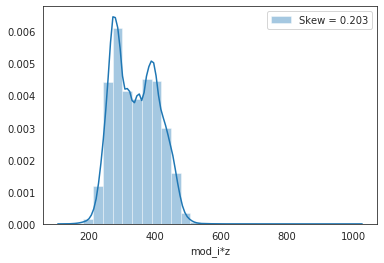

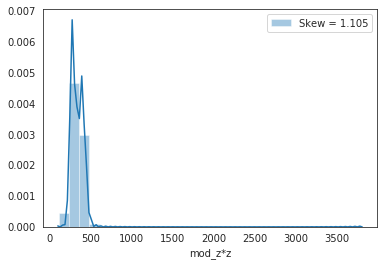

In [0]:
#왜도 확인

for feat in col_list:
    skew = train[feat].skew()
    sns.distplot(train[feat], kde= True, label='Skew = %.3f' %(skew), bins=30)
    plt.legend(loc='best')
    plt.show()

In [0]:
for col in col_list:
  #transform training data & save lambda value
  train[col],fitted_lambda = stats.boxcox(train[col])

#   # use lambda value to transform test data
#   test[col] = stats.boxcox(test[col], fitted_lambda)

#   fig, ax=plt.subplots(1,2)
#   sns.distplot(train[col], ax=ax[0])
#   sns.distplot(test[col], ax=ax[1])

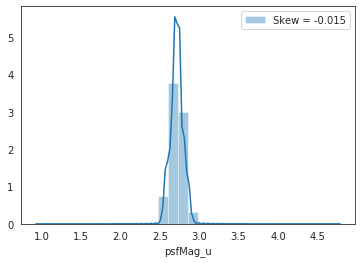

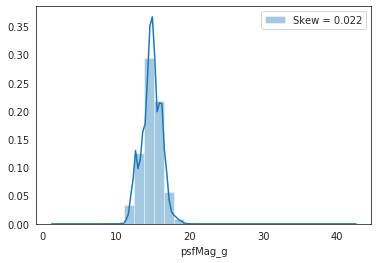

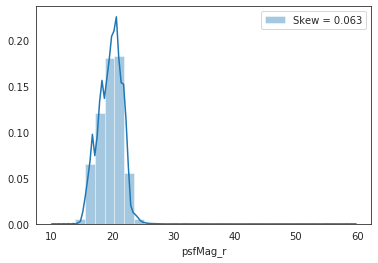

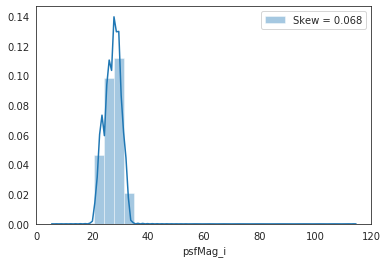

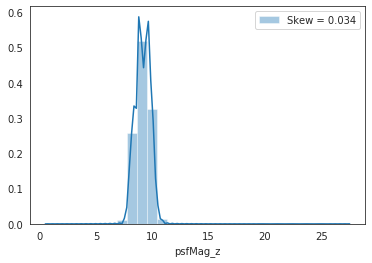

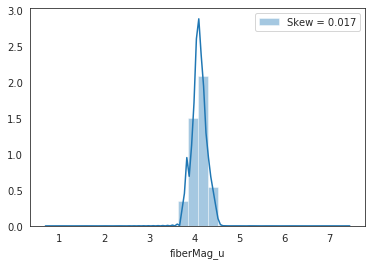

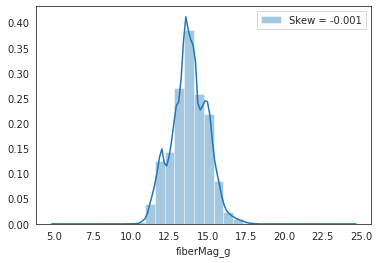

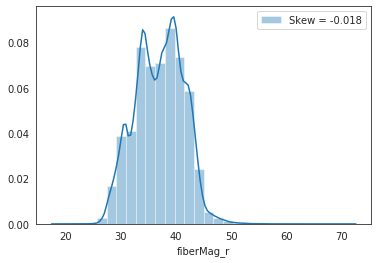

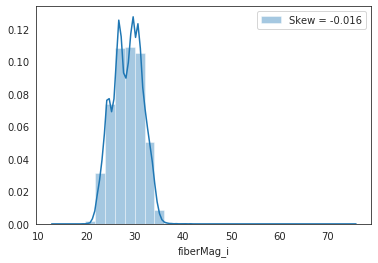

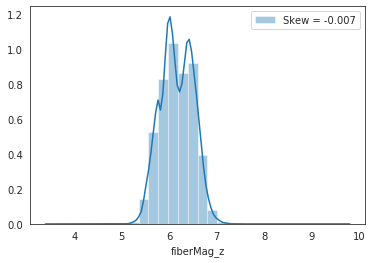

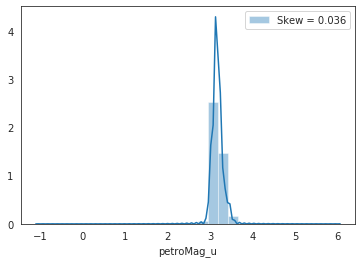

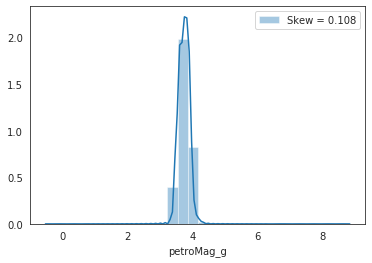

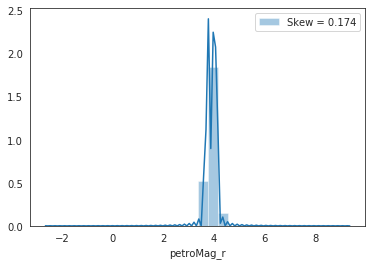

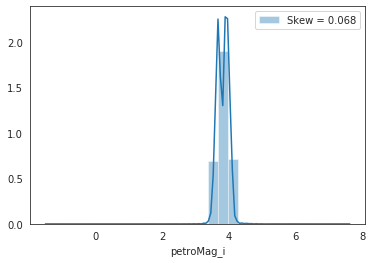

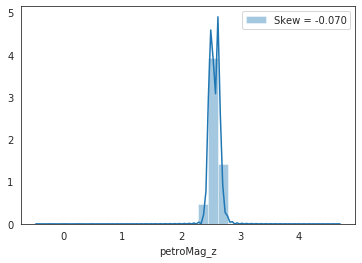

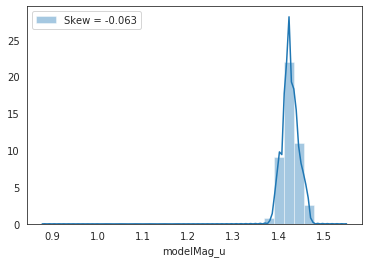

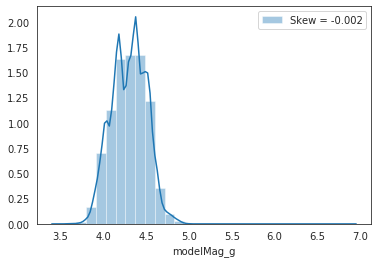

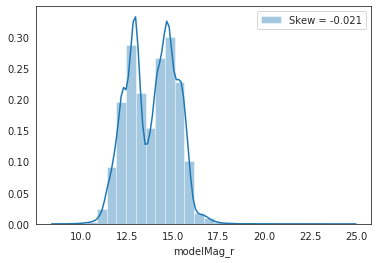

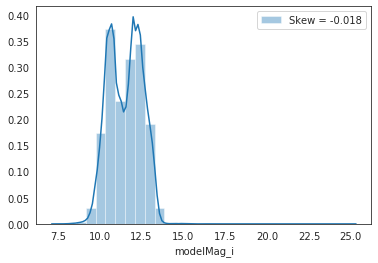

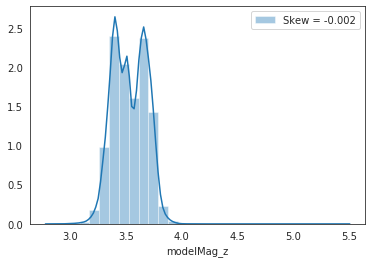

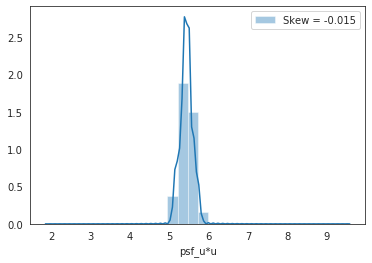

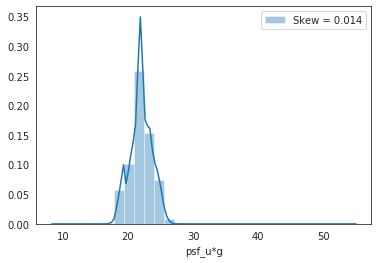

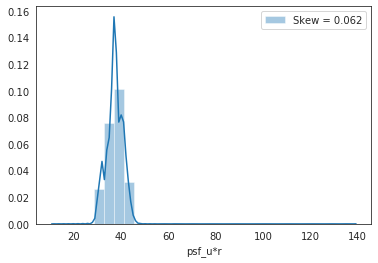

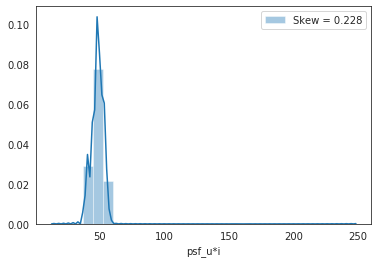

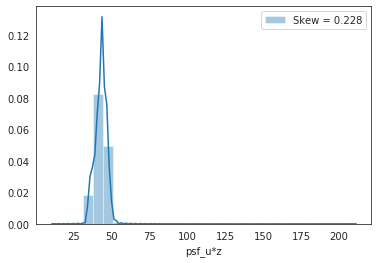

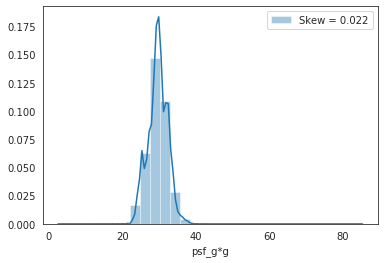

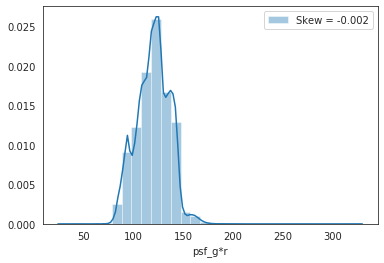

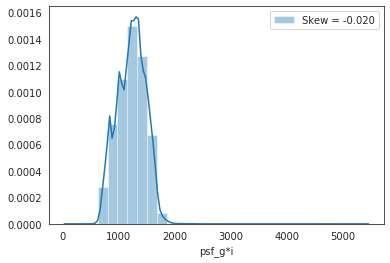

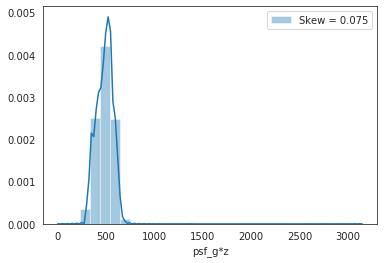

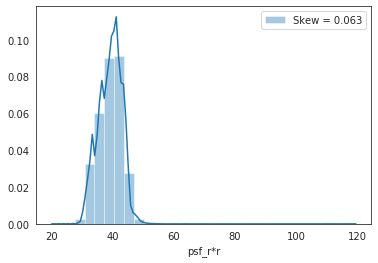

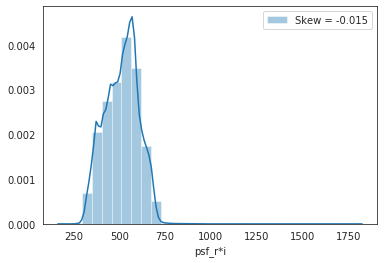

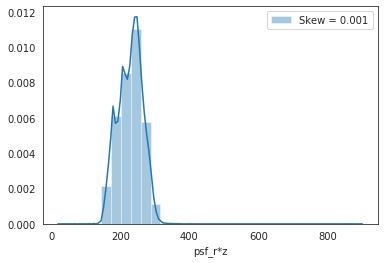

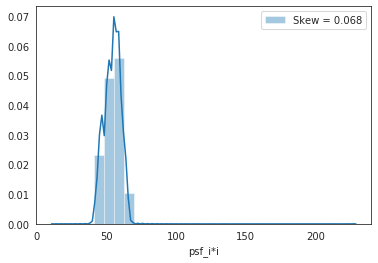

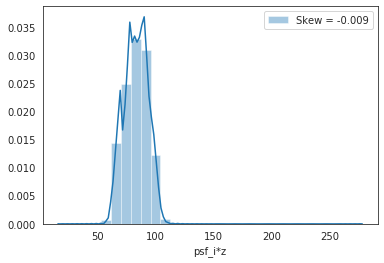

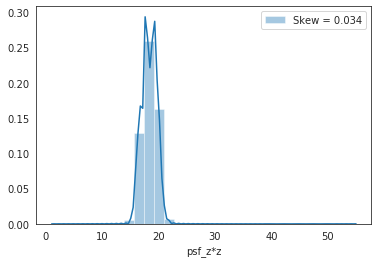

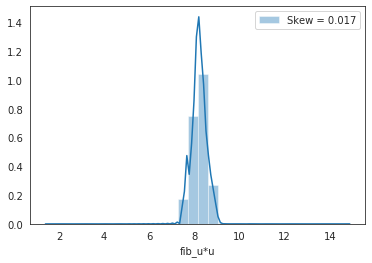

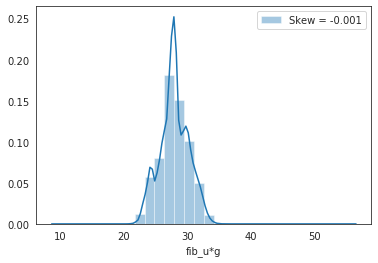

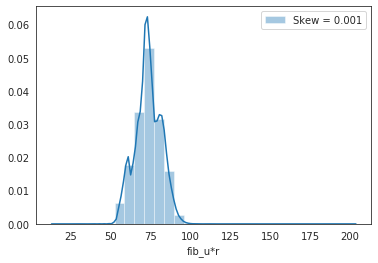

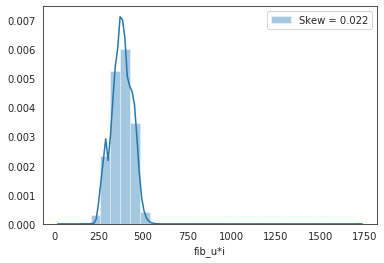

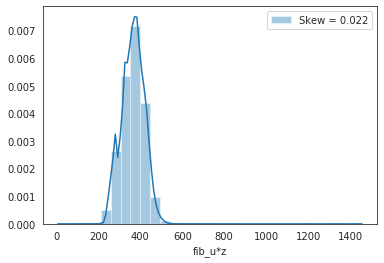

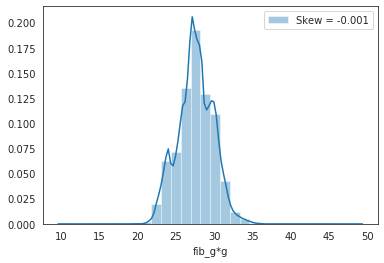

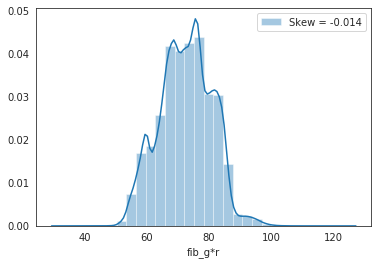

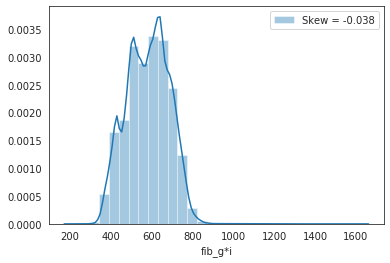

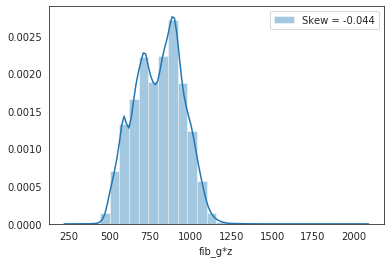

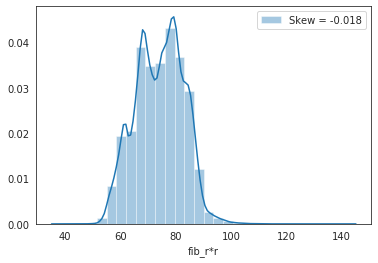

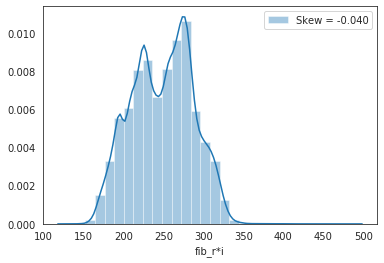

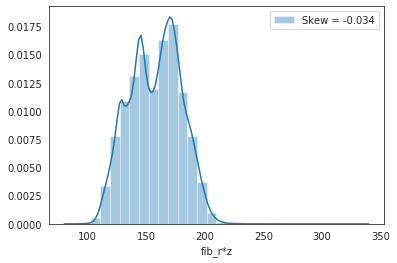

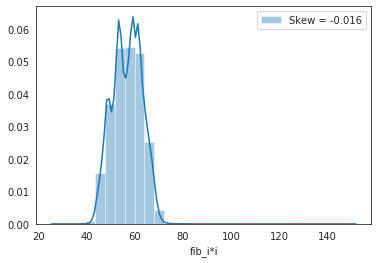

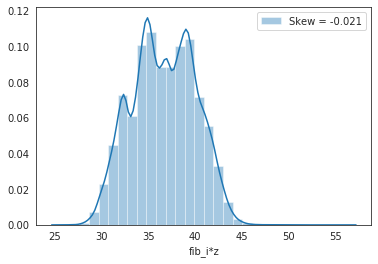

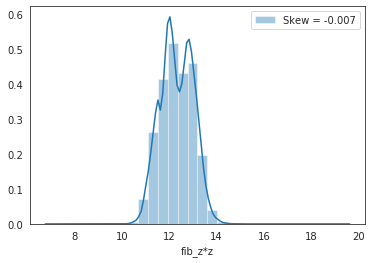

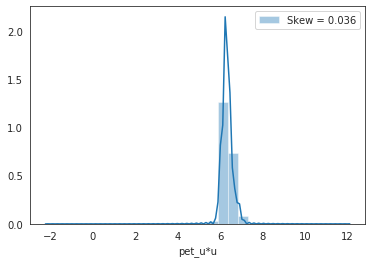

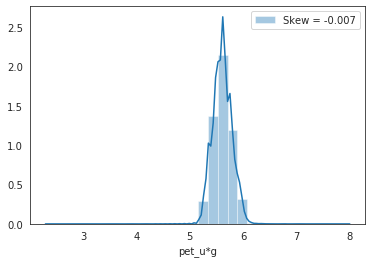

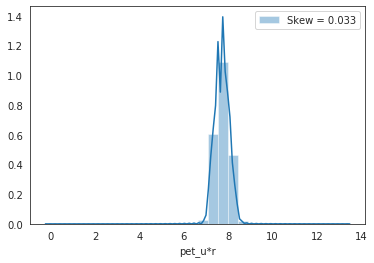

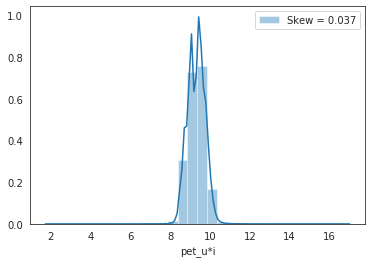

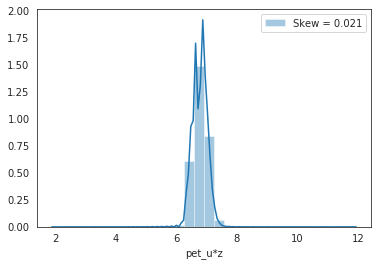

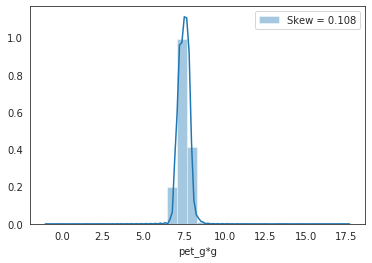

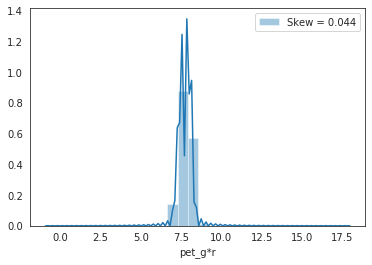

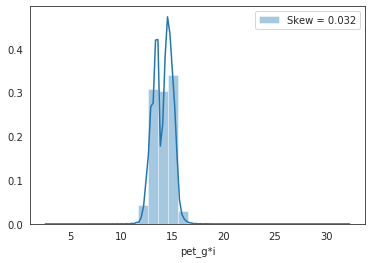

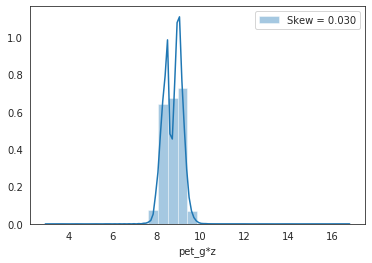

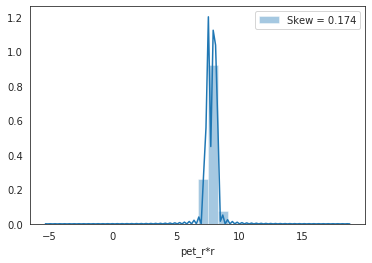

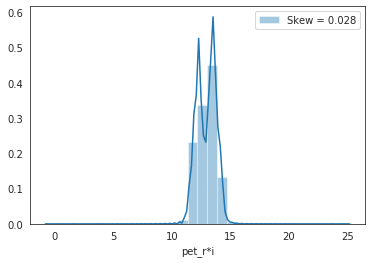

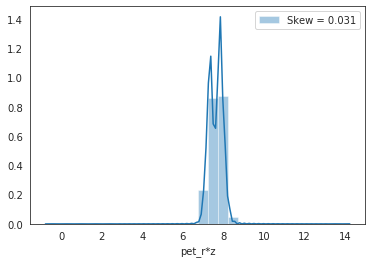

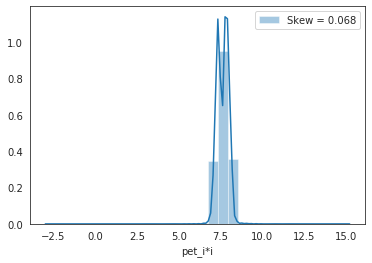

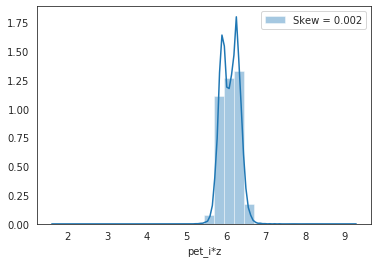

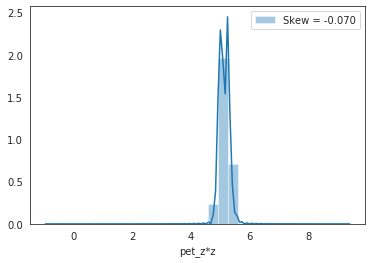

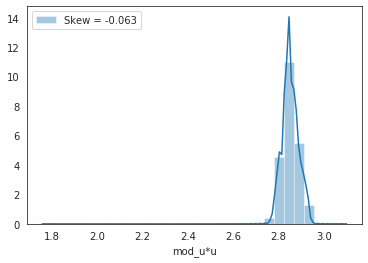

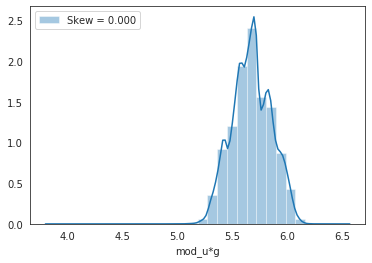

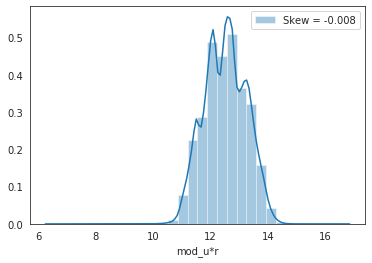

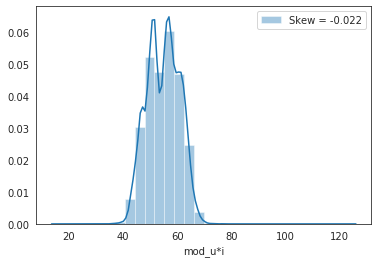

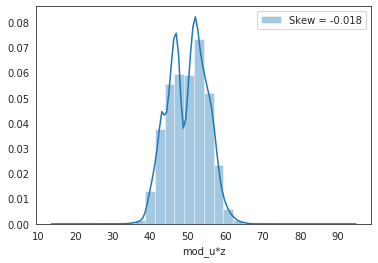

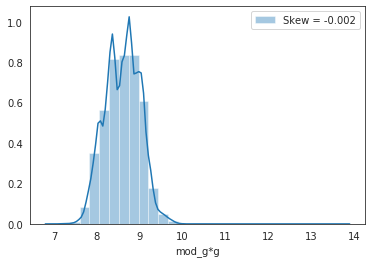

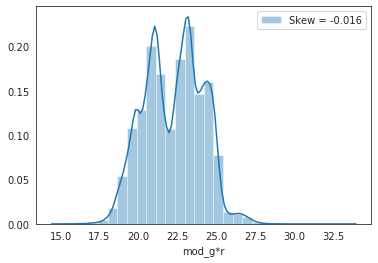

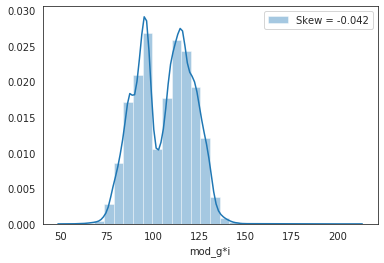

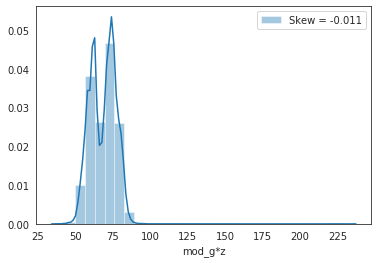

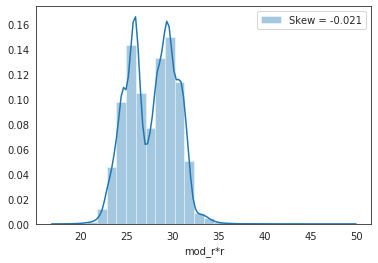

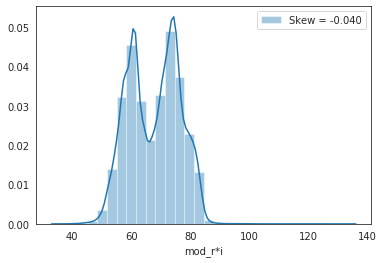

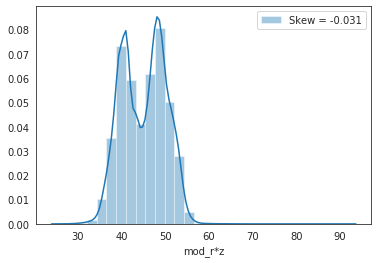

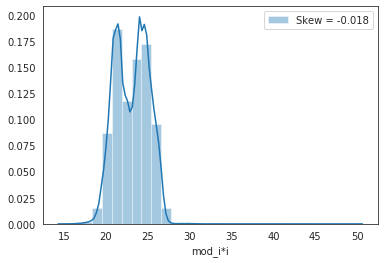

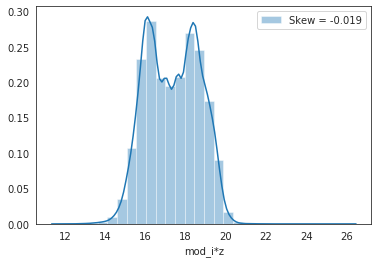

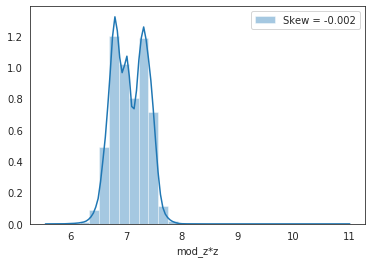

In [0]:
#왜도 확인

for feat in col_list:
    skew = train[feat].skew()
    sns.distplot(train[feat], kde= True, label='Skew = %.3f' %(skew), bins=30)
    plt.legend(loc='best')
    plt.show()

## 정규화

In [0]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
for data in [train,test]:
  stdsc.fit(data[col_list])
  data[col_list]=stdsc.transform(data[col_list])

## 독립, 종속 변수 분할

In [0]:
y_data = train['type']
X_data =  train.drop(train[['id','fiberID','type']],axis=1)
test_data = test.drop(test[['id','fiberID']],axis=1)

# RandomForest 변수 추출 

( 너무 오래 걸리므로 PCA를 해보자)
- 랜덤 포레스트에서 두 개 이상의 특성이 매우 상관관계가 높다면 하나의 특성은 매우 높은 순위를 갖지만 다른 특성 정보는 완전히 잡아내지 못하는 경우가 있다.
 - 특성 중요도 값을 해석하는 것보다 모델의 예측 성능에만 관심이 있다면 크게 신경쓰지 않아도 됨.

In [0]:
# feat_labels= X_data.columns[:]

# clf = RandomForestClassifier(n_estimators=500,
#                              random_state=1,
#                              n_jobs=-1)
# clf.fit(X_data,y_data)
# importances = clf.feature_importances_

# indices = np.argsort(importances)[::-1]

# for f in range(X_data.shape[1]):
#   print('%2d)%-*s %f' %(f+1,30,
#                         feat_labels[indices[f]],
#                         importances[indices[f]]))
# plt.title('Feature Importance')
# plt.bar(range(X_data.shape[1]),
#               importances[indices],
#               align='center')

# plt.xticks(range(X_data.shape[1]),
#            feat_labels[indices],rotation=90)
# plt.xlim([-1,X_data.shape[1]])
# plt.tight_layout()
# plt.show()

# LDA

In [0]:
X_data.corr()

,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z,psf_u*u,psf_u*g,psf_u*r,psf_u*i,psf_u*z,psf_g*g,psf_g*r,psf_g*i,psf_g*z,psf_r*r,psf_r*i,psf_r*z,psf_i*i,psf_i*z,psf_z*z,fib_u*u,fib_u*g,fib_u*r,fib_u*i,fib_u*z,fib_g*g,fib_g*r,fib_g*i,fib_g*z,fib_r*r,fib_r*i,fib_r*z,fib_i*i,fib_i*z,fib_z*z,pet_u*u,pet_u*g,pet_u*r,pet_u*i,pet_u*z,pet_g*g,pet_g*r,pet_g*i,pet_g*z,pet_r*r,pet_r*i,pet_r*z,pet_i*i,pet_i*z,pet_z*z,mod_u*u,mod_u*g,mod_u*r,mod_u*i,mod_u*z,mod_g*g,mod_g*r,mod_g*i,mod_g*z,mod_r*r,mod_r*i,mod_r*z,mod_i*i,mod_i*z,mod_z*z
psfMag_u,1.000000,0.883798,0.757463,0.566883,0.417268,0.940239,0.871706,0.731898,0.537015,0.389036,0.787592,0.763792,0.624117,0.456517,0.320687,0.912679,0.798439,0.643556,0.459602,0.328364,1.000000,0.973493,0.947128,0.904360,0.856330,0.883798,0.834371,0.768085,0.710439,0.757463,0.670063,0.604526,0.566883,0.491873,0.417268,0.940239,0.932546,0.895449,0.841107,0.788386,0.871706,0.815137,0.745222,0.685851,0.731898,0.642981,0.576654,0.537015,0.464589,0.389036,0.787592,0.828866,0.779211,0.723272,0.665355,0.763792,0.715544,0.653493,0.596719,0.624117,0.556807,0.495680,0.456517,0.397656,0.320687,0.912679,0.880914,0.832616,0.779992,0.729189,0.798439,0.731402,0.661566,0.605188,0.643556,0.559193,0.497910,0.459602,0.395026,0.328364
psfMag_g,0.883798,1.000000,0.928579,0.767192,0.625461,0.886733,0.978391,0.914119,0.750735,0.606846,0.757371,0.892772,0.815341,0.672911,0.535035,0.873611,0.930109,0.839269,0.684013,0.555375,0.883798,0.965957,0.962126,0.932168,0.896018,1.000000,0.983169,0.942510,0.895478,0.928579,0.864144,0.806404,0.767192,0.699172,0.625461,0.886733,0.958437,0.959550,0.926025,0.882958,0.978391,0.962198,0.918250,0.869714,0.914119,0.846939,0.787644,0.750735,0.682450,0.606846,0.757371,0.878729,0.860720,0.821074,0.771801,0.892772,0.880094,0.837971,0.788052,0.815341,0.767968,0.710879,0.672911,0.619138,0.535035,0.873611,0.924988,0.909325,0.875409,0.834073,0.930109,0.898002,0.852130,0.803638,0.839269,0.774088,0.718203,0.684013,0.622450,0.555375
psfMag_r,0.757463,0.928579,1.000000,0.903425,0.801889,0.764111,0.929882,0.973142,0.894347,0.791901,0.673894,0.871445,0.894348,0.820108,0.710472,0.772635,0.908023,0.921224,0.839572,0.746610,0.757463,0.861835,0.923233,0.925628,0.917974,0.928579,0.979542,0.972278,0.953811,1.000000,0.974018,0.942377,0.903425,0.859182,0.801889,0.764111,0.868395,0.919912,0.929783,0.918067,0.929882,0.965424,0.966347,0.948337,0.973142,0.951893,0.920445,0.894347,0.849386,0.791901,0.673894,0.822150,0.852899,0.849586,0.823675,0.871445,0.908740,0.903353,0.876047,0.894348,0.885274,0.847353,0.820108,0.785747,0.710472,0.772635,0.860119,0.893598,0.897647,0.884349,0.908023,0.926822,0.920767,0.899002,0.921224,0.896264,0.864370,0.839572,0.798340,0.746610
psfMag_i,0.566883,0.767192,0.903425,1.000000,0.950588,0.574733,0.770003,0.895334,0.970392,0.937977,0.518050,0.725423,0.825351,0.890057,0.838515,0.588890,0.761206,0.851506,0.913824,0.880357,0.566883,0.677581,0.764458,0.857288,0.884493,0.767192,0.843216,0.932212,0.949853,0.903425,0.974352,0.975873,1.000000,0.985395,0.950588,0.574733,0.685966,0.770901,0.855908,0.890868,0.770003,0.841731,0.916693,0.944684,0.895334,0.952229,0.963401,0.970392,0.963285,0.937977,0.518050,0.662393,0.727464,0.792385,0.804214,0.725423,0.797835,0.859783,0.869729,0.825351,0.885428,0.883429,0.890057,0.888690,0.838515,0.588890,0.688663,0.753168,0.824666,0.850721,0.761206,0.814370,0.878371,0.895276,0.851506,0.899536,0.903919,0.913824,0.904925,0.880357
psfMag_z,0.417268,0.625461,0.801889,0.950588,1.000000,0.424031,0.625139,0.792830,0.940860,0.966062,0.398437,0.603802,0.742794,0.863965,0.874942,0.448867,0.634506,0.765315,0.888732,0.915673,0.417268,0.526153,0.627035,0.740859,0.820241,0.625461,0.716498,0.826085,0.902515,0.801889,0.895656,0.953411,0.950588,0.988918,1.000000,0.424031,0.532572,0.632604,0.748221,0.815731,0.625139,0.714430,0.8202

In [0]:
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# lda = LinearDiscriminantAnalysis(n_components=20)
# lda.fit(X_data,y_data)
# X_lda = lda.transform(X_data)
# test_lda = lda.transform(test_data)
# X_lda.shape


cross_val_score 파라미터 참고:https://scikit-learn.org/stable/modules/model_evaluation.html

In [0]:
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# for n in range(1,11):
#   lda = LinearDiscriminantAnalysis(n_components=n)
#   lda.fit(X_data,y_data)
#   data_lda = lda.transform(X_data)

#   rlf = RandomForestClassifier(n_estimators=300,
#                                random_state=156,
#                                n_jobs=-1)
  
#   scores_lda = cross_val_score(rlf,X_data,y_data,scoring='neg_log_loss',cv=5)
#   print('n_components가 %d개인 경우'%(n))
#   print('평균 f1-score:{0:.4f}'.format(np.mean(scores_lda)))

# 하이퍼 파라미터 튜닝

# 데이터 분리
- 데이터가 Unbalanced하기 때문에 Stratified K 폴드 검증을 사용할 것이다.

In [0]:
# from sklearn.model_selection import StratifiedKFold

# skf = StratifiedKFold(n_splits=5,shuffle=True)
# n_iter=0

# for train_index,test_index in skf.split(X_data,y_data):
#   n_iter+=1
#   label_train = y_data.iloc[train_index]
#   label_test = y_data.iloc[test_index]
#   print('## 교차 검증: {0}'.format(n_iter))
#   print('학습 레이블 데이터 분포: \n', label_train.value_counts())
#   print('검증 레이블 데이터 분포: \n', label_test.value_counts())

In [0]:
X_train,X_test,y_train,y_test = train_test_split(X_data,y_data,test_size=0.3,random_state=156)
                                                #X_lda
#Smote 오버샘플링
from imblearn.over_sampling import SMOTE

# 모델설정
sm = SMOTE(ratio='auto', kind='regular')

# train데이터를 넣어 복제함
X_resampled, y_resampled = sm.fit_sample(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

# 모델링

## RandomForestClassifier

In [0]:
# RandomForestClassifier

# rlf = RandomForestClassifier(n_estimators=300,
#                                random_state=156,
#                                n_jobs=-1)

# scores_lda = cross_val_score(rlf,data_lda,y_data,scoring='neg_log_loss',cv=5)
# print('n_components가 %d개인 경우'%(n))
# print('평균 f1-score:{0:.4f}'.format(np.mean(scores_lda)))

## XgBoost

In [0]:
# from sklearn.model_selection import GridSearchCV
# from xgboost import XGBClassifier

# XGB_clf = XGBClassifier(n_estimators=1000,objective= 'multiclass')

# params = {'num_leaves':[32,64,128],
#           'max_depth':[84,128,160],
#           'min_child_samples':[60,100,160,200],
#           'subsample':[0.8,1]}

# gridcv = GridSearchCV(XGB_clf,param_grid=params)
# gridcv.fit(X_resampled,y_resampled,early_stopping_rounds=30,eval_metric='logloss',
#            eval_set=[(X_resampled,y_resampled),(X_test,y_test)])
# print('GridSearchCV 최적파라미터:',gridcv.best_params)

In [0]:
#np.unique(y_resampled)
#np.unique(y_test)

In [0]:
# %%time
# from xgboost import XGBClassifier

# XGB_clf = XGBClassifier(n_esetimators=1000,
#                         n_jobs=-1,
#                         max_depth=8,       # 3~10
#                         eta=0.15,          # 0.01~0.2
#                         objective= 'multiclass',          
#                         random_state=156)
# XGB_clf.fit(X_resampled,y_resampled,
#             eval_set=[(X_resampled, y_resampled), (X_test, y_test)],
#             eval_metric='mlogloss')

In [0]:
# preds = XGB_clf.predict_proba(test_lda)

## LGBM

In [0]:
from lightgbm import LGBMClassifier

In [0]:
lgbm_clf = LGBMClassifier(n_estimators=8000,
                          learnig_rate=0.2,
                          n_jobs=-1,
                          num_leaves=256,
                          max_depth=8,
                          num_class=19,
                          #lambda_l1 = 2.0,
                          objective = 'multi:softmax',
                          random_state=156)
lgbm_clf.fit(X_resampled, y_resampled,
             early_stopping_rounds=30,
             eval_set=[(X_resampled, y_resampled), (X_test, y_test)],
             verbose=True)

[1]	training's multi_logloss: 2.27442	valid_1's multi_logloss: 2.31249
Training until validation scores don't improve for 30 rounds.
[2]	training's multi_logloss: 1.96067	valid_1's multi_logloss: 2.01817
[3]	training's multi_logloss: 1.74541	valid_1's multi_logloss: 1.81605
[4]	training's multi_logloss: 1.57881	valid_1's multi_logloss: 1.65965
[5]	training's multi_logloss: 1.44262	valid_1's multi_logloss: 1.53095
[6]	training's multi_logloss: 1.32909	valid_1's multi_logloss: 1.42354
[7]	training's multi_logloss: 1.23172	valid_1's multi_logloss: 1.33219
[8]	training's multi_logloss: 1.14686	valid_1's multi_logloss: 1.25307
[9]	training's multi_logloss: 1.07249	valid_1's multi_logloss: 1.18411
[10]	training's multi_logloss: 1.00695	valid_1's multi_logloss: 1.12295
[11]	training's multi_logloss: 0.949222	valid_1's multi_logloss: 1.06955
[12]	training's multi_logloss: 0.897021	valid_1's multi_logloss: 1.02084
[13]	training's multi_logloss: 0.849645	valid_1's multi_logloss: 0.977102
[14]	tr

In [0]:
# Grid Search

from sklearn.model_selection import GridSearchCV

lgbm_clf = LGBMClassifier(n_estimators=1500,random_state=156)

params = {'num_leaves':[32,64,128],
          'max_depth':[5,10,20,30,40,50,100],
          'min_child_samples':[60,100,160,200],
          'subsample':[0.8,1],
          'objective':['multi:softmax'],
          'num_class':[19]}

gridcv = GridSearchCV(lgbm_clf,param_grid=params)
gridcv.fit(X_resampled,y_resampled,early_stopping_rounds=30,eval_metric='mlogloss',
           eval_set=[(X_resampled,y_resampled),(X_test,y_test)])
print('GridSearchCV 최적파라미터:',gridcv.best_params)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
lightgbm.basic.LightGBMError: Multiclass objective and metrics don't match

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: y contains previously unseen labels: [0]

  FitFailedWarning)


KeyboardInterrupt: ignored

### Submit

In [0]:
preds = lgbm_clf.predict_proba(test_data)

submission = pd.DataFrame(preds)
submission

submission = pd.concat([test_id, submission], axis=1)

sample_submission.columns

submission.columns=['id', 'STAR_WHITE_DWARF', 'STAR_CATY_VAR', 'STAR_BROWN_DWARF',
       'SERENDIPITY_RED', 'REDDEN_STD', 'STAR_BHB', 'GALAXY',
       'SERENDIPITY_DISTANT', 'QSO', 'SKY', 'STAR_RED_DWARF', 'ROSAT_D',
       'STAR_PN', 'SERENDIPITY_FIRST', 'STAR_CARBON', 'SPECTROPHOTO_STD',
       'STAR_SUB_DWARF', 'SERENDIPITY_MANUAL', 'SERENDIPITY_BLUE']

submission.to_csv('/content/drive/My Drive/Colab Notebooks/data/데이콘/천체 유형 분류/submission_Xgboost_LDA.csv')